# Marginal Likelihood in Python and PyMC3

This blog post is based on the paper reading of [A Tutorial on Bridge Sampling](https://arxiv.org/abs/1703.05984), which gives an excellent review of the computation of marginal likelihood, and also an introduction of Bridge sampling. Here I will replicate these computations in Python and PyMC3, implementing especially the Bridge sampling technique. An R implementation of Bridge sampling is available on [Github](https://github.com/quentingronau/bridgesampling) with [the paper](https://arxiv.org/pdf/1710.08162.pdf).  

**!Warning!: Marginal likelihood (and Bayes Factor) is extremely sensitive to your model parameterisation (particularly the priors). You should be aware of which part of the model the marginal likelihood is sensitive to, and have a clear justification of these parts. Otherwise, Bayes Factors are too easy to game and you will most likely fool yourself.**

In [1]:
import numpy as np
import pymc3 as pm
import seaborn as sns
import scipy.stats as st
import theano.tensor as tt

%pylab inline
%config InlineBackend.figure_format = 'retina'

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


The marginal likelihood is defined as follow:  

$$
p(y \mid \text{Model}) = \int p(y \mid \theta, \text{Model}) p(\theta \mid \text{Model}) d \theta
$$
where $y$ is the observed data, and $\text{Model}$ is the model/parameterization. If you interprete the marginal likelihood as a weighted average of the likelihood of the data given the prior $p(\theta \mid \text{Model})$, you can rewrite marginal likelihood as an expectation:  

$$
p(y \mid \text{Model}) = \mathbb{E}_{prior} [ p(y \mid \theta, \text{Model}) ]
$$

The upside of thinking regarding Expectation is that, using Monte Carlo simulation, we can think of simulating lots of samples and take their average.

## The Running Example: The Beta-Binomial Model

$$ \theta \sim \text{Beta}(1,1) $$
$$ k \sim \text{Binomial}(\theta,n)$$

With a Conjugate prior, this becomes a Beta-Binomial model where the analytical solution is aviable:  
Posterior
$$ \theta \mid n, k \sim \text{Beta}(k+1, n-k+1) $$
and the marginal
$$ p (k \mid n) = \int^1_0 p (k \mid \theta, n) p (\theta) d (\theta) = \dfrac{1}{n+1}$$

The running example is based on the [R code](https://osf.io/5eka2/) accompany with the Tutorial paper on Bridge Sampling. More details please see the paper.

In [2]:
# Observed Data
k = 2
n = 10
# Prior parameters for Beta
alpha = beta = 1

### The Analytical Solution

In [3]:
# Exact Calculation
m_l = 1/(n + 1)
print('The analytical solution of the marginal likelihood is %.5f'%(m_l))

The analytical solution of the marginal likelihood is 0.09091


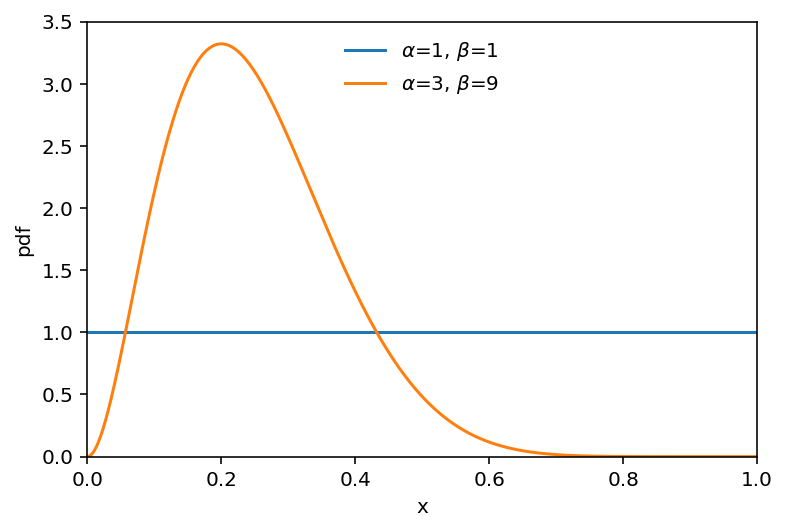

In [4]:
x = np.linspace(0.0, 1.0, 1000)
f = lambda a, b : st.beta.pdf(x, a, b)

fig, ax = plt.subplots()
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\alpha$={0}, $\beta$={1}'.format(a,b))
plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='pdf')
plt.show()

### The Naive Monte Carlo Estimator

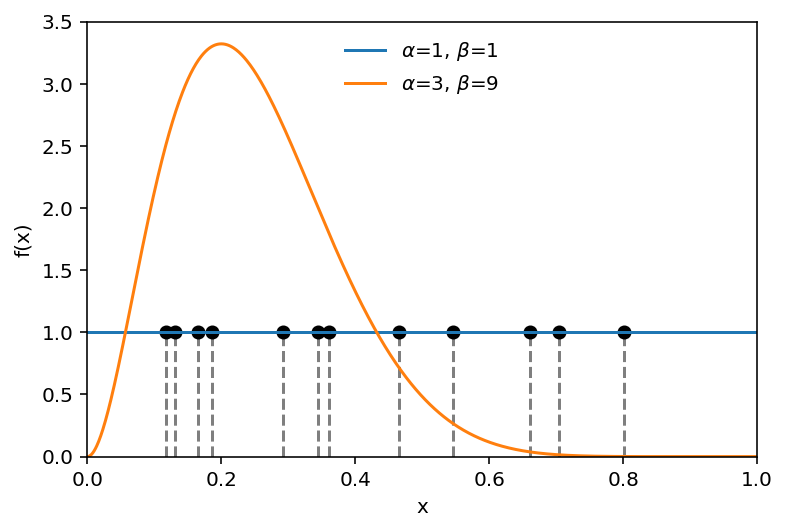

The Naive Monte Carlo Estimation is 0.14593


In [5]:
N=12
prior_samples = st.beta.rvs(alpha, beta, size=N)

fig, ax = plt.subplots()
betap = st.beta.pdf(prior_samples, alpha, beta)
ax.plot(prior_samples, betap, 'ko')
ax.plot([prior_samples, prior_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)

plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0, 1], ylim=[0, 3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_n = st.binom.pmf(k, n, p=prior_samples).mean()
print('The Naive Monte Carlo Estimation is %.5f'%(m_l_n))

Naive Monte Carlo Estimation using PyMC3 model

In [6]:
# Set up PyMC3 model
with pm.Model() as BB:
    p = pm.Beta('p', alpha=1., beta=1., transform=None)
    obs = pm.Binomial('obs', p=p, n=n, observed=k)

Get the log-probability function from PyMC3 model. I should point out that when I am defining the model in above, I set the `transform=None` for the Beta distribution. In general, PyMC3 transformed the bounded parameters to Real line, however, doing so here the logp function will evaluate on the _transformed_ input.

In [7]:
# from pymc3.model import Point
# from pymc3.blocking import DictToArrayBijection, ArrayOrdering

# start = Point(BB.test_point, model=BB)
# bij = DictToArrayBijection(ArrayOrdering([p]), start)
# logp_func = bij.mapf(obs.fastlogp_nojac)

logp_func = BB.logp_array

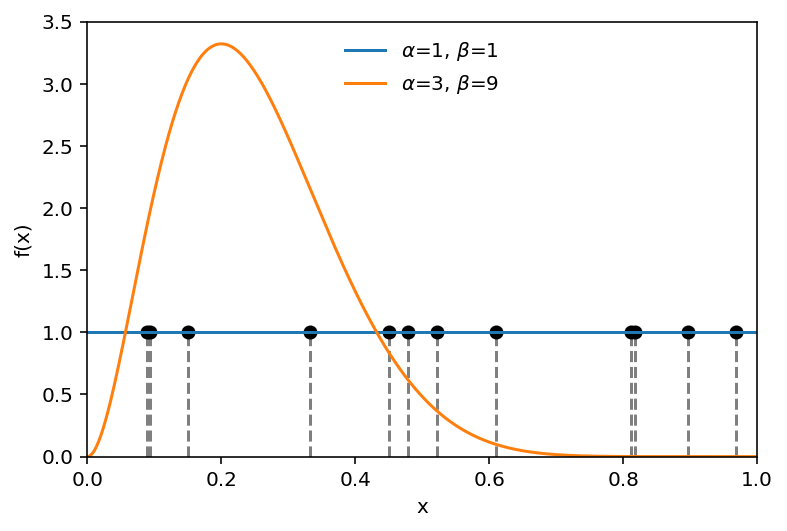

The Naive Monte Carlo Estimation is 0.08297


In [8]:
prior_samples = p.random(size=N)

fig, ax = plt.subplots()
betap = st.beta.pdf(prior_samples, alpha, beta)
ax.plot(prior_samples, betap, 'ko')
ax.plot([prior_samples, prior_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
plot_pdf(alpha, beta)
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_n = np.exp(np.array([logp_func(p) for p in prior_samples])).mean()
print('The Naive Monte Carlo Estimation is %.5f'%(m_l_n))

### The Importance Sampling Estimator

In [9]:
# helper functions
def posterior_ab(post_samples):
    # use properties from the posterior in order to create g
    mu_post = np.mean(post_samples)
    var_post = np.var(post_samples)

    # use method of moments to obtain best fitting beta distribution
    a_g = mu_post*(mu_post*(1 - mu_post)/var_post - 1)
    b_g = (1 - mu_post)*(mu_post*(1 - mu_post)/var_post - 1)
    return a_g, b_g

# mixture distribution
def betamix_pdf(x, w, a_g, b_g):
    return w*st.beta.pdf(x, alpha, beta) + (1-w)*st.beta.pdf(x, a_g, b_g)

# mixture samples
def betamix_rvs(N, w, a_g, b_g):
    mix_ind = np.random.choice(2, N, p=[w, 1-w])
    betamix_rv = np.hstack((st.beta.rvs(alpha, beta, size=(N, 1)),
                            st.beta.rvs(a_g, b_g, size=(N, 1))))
    return betamix_rv[range(N), mix_ind]

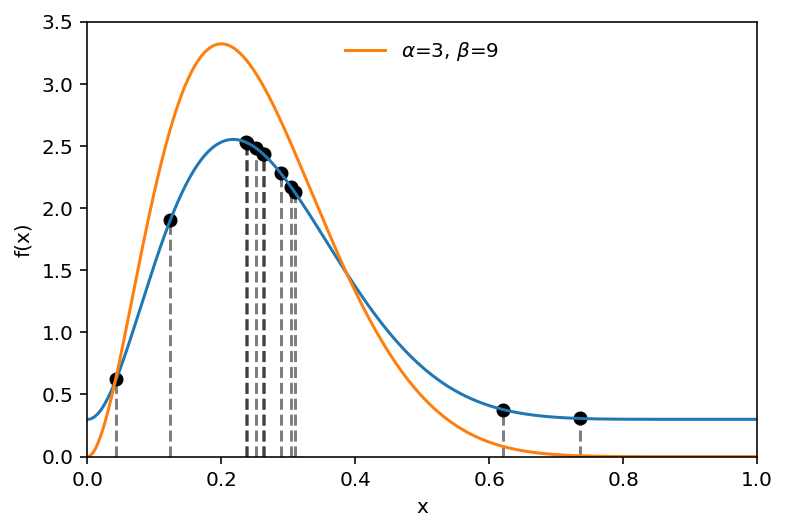

The Importance Sampling Estimation is 0.09366


In [13]:
w = .3
# Draw from the posterior and create a Important Density g_IS(theta)
post_samples = st.beta.rvs(k+alpha, n-k+beta, size=N)

a_g, b_g = posterior_ab(post_samples)
g_samples = betamix_rvs(N, w, a_g, b_g)
betap = betamix_pdf(g_samples, w, a_g, b_g)

fig, ax = plt.subplots()
ax.plot(g_samples, betap, 'ko')
ax.plot([g_samples, g_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
ax.plot(x, betamix_pdf(x, w, a_g, b_g))
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_i = (st.binom.pmf(k, n, p=g_samples)*st.beta.pdf(g_samples, alpha, beta)/
        betamix_pdf(g_samples, w, a_g, b_g)).mean()
print('The Importance Sampling Estimation is %.5f'%(m_l_i))

In [14]:
# Set up PyMC3 model
with pm.Model() as BB:
    p = pm.Beta('p', alpha=1., beta=1.)
    obs = pm.Binomial('obs', p=p, n=n, observed=k)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_logodds__]
100%|██████████| 1000/1000 [00:01<00:00, 572.43it/s]
The acceptance probability does not match the target. It is 0.8915245987248915, but should be close to 0.8. Try to increase the number of tuning steps.


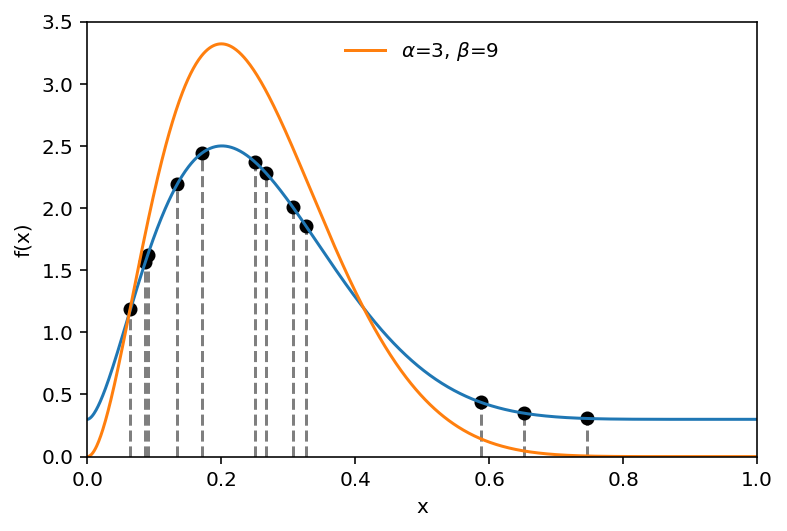

The Importance Sampling Estimation is 0.08668


In [15]:
post_samples = trace['p']

a_g, b_g = posterior_ab(post_samples)
g_samples = betamix_rvs(N, w, a_g, b_g)
betap = betamix_pdf(g_samples, w, a_g, b_g)

fig, ax = plt.subplots()
ax.plot(g_samples, betap, 'ko')
ax.plot([g_samples, g_samples],
        [np.zeros_like(betap), betap], 'k--', alpha=.5)
ax.plot(x, betamix_pdf(x, w, a_g, b_g))
plot_pdf(k+alpha, n-k+beta)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[0,1], ylim=[0,3.5], xlabel='x', ylabel='f(x)')
plt.show()

m_l_i = (st.binom.pmf(k, n, p=g_samples)*st.beta.pdf(g_samples, alpha, beta)/
        betamix_pdf(g_samples, w, a_g, b_g)).mean()
print('The Importance Sampling Estimation is %.5f'%(m_l_i))

### The Generalized Harmonic Mean Estimator

The Generalized Harmonic Mean is 0.09423


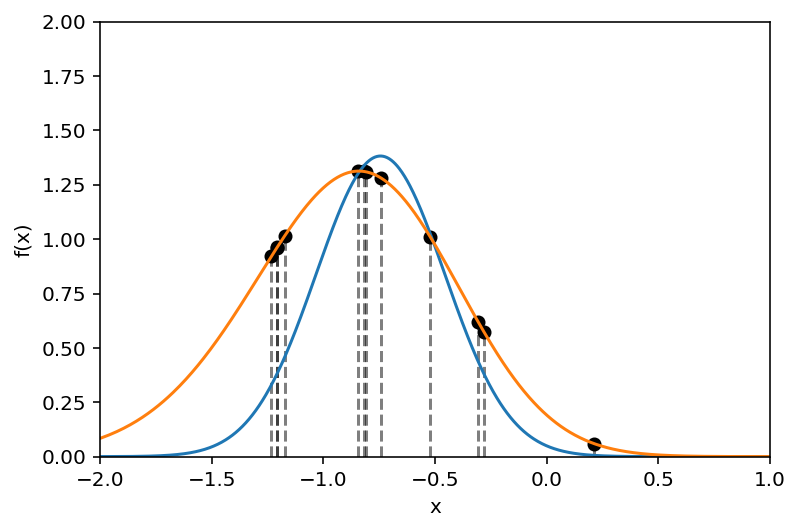

In [16]:
post_samples = st.beta.rvs(k+alpha, n-k+beta, size=N)

# probit-transform posterior samples
probit = st.norm.ppf
probit_post_samples = probit(post_samples)

# correct for change of coordinates, not sure if my derivation is correct 
scale = np.log(np.abs((2/np.sqrt(np.pi) * exp(-post_samples**2)).sum()))

mu_probit = np.mean(probit_post_samples)
sd_probit = np.std(probit_post_samples)

sd_g_is = sd_probit/1.5

m_l_gh = 1/(st.norm.pdf(probit_post_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(probit_post_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

x1 = np.linspace(-2, 1, 1000)

fig, ax = plt.subplots()
betap = st.beta.pdf(post_samples, k+alpha, n-k+beta)
ax.plot(probit_post_samples, betap/scale, 'ko')
ax.plot([probit_post_samples, probit_post_samples],
        [np.zeros_like(betap), betap/scale], 'k--', alpha=.5)
ax.plot(x1, st.norm.pdf(x1, mu_probit, sd_g_is))
ax.plot(probit(x), st.beta.pdf(x, k+alpha, n-k+beta)/scale)
plt.legend(loc='upper center', frameon=False)
ax.set(xlim=[-2,1], ylim=[0,2], xlabel='x', ylabel='f(x)')
plt.show()

In [17]:
post_samples = trace['p']

# probit-transform posterior samples
probit_post_samples = probit(post_samples)

mu_probit = np.mean(probit_post_samples)
sd_probit = np.std(probit_post_samples)

sd_g_is = sd_probit/1.5

m_l_gh = 1/(st.norm.pdf(probit_post_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(probit_post_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

The Generalized Harmonic Mean is 0.09303


The posterior sample from PyMC3 is already on a Real line (it transform the paremeters internally for NUTS sampling), we can skip the step of probit transformation.

In [18]:
logit_samples = trace['p_logodds__']

mu_probit = np.mean(logit_samples)
sd_probit = np.std(logit_samples)

sd_g_is = sd_probit/2

m_l_gh = 1/(st.norm.pdf(logit_samples, mu_probit, sd_g_is)/
         (st.binom.pmf(k, n, p=post_samples)*
            st.norm.pdf(logit_samples, 0, 1))).mean()
print('The Generalized Harmonic Mean is %.5f'%(m_l_gh))

The Generalized Harmonic Mean is 0.09549


### The Bridge Sampling Estimator
The Bridge Sampling Estimator is a general case of method 1-3 above (more details see Appendix A in the paper). The general idea is to build an Importance density using the posterior (for the easy generation of samples), and use a bridge function to "bridge" between the importance samples and the posterior samples.  

It goes as the following:

- Draw `2*N1` samples from the $\text{Beta}(3, 9)$ posterior for theta.

In [19]:
N1 = 12
theta_star = st.beta.rvs(k+alpha, n-k+beta, size=N1*2)

- Choose a proposal distribution.  
_Here using normal distribution as in the paper._  

  
- Transform the first batch of `N1` posterior samples. Using a Probit transform here.

In [20]:
theta_star_4_fit = theta_star[:N1]
xi_star_4_fit = probit(theta_star_4_fit)

- Fit the proposal distribution to the first batch of `N1` probit-transformed posterior samples.

In [21]:
mu_hat = np.mean(xi_star_4_fit)
sigma_hat = np.std(xi_star_4_fit)

- Draw `N2` samples from the proposal distribution.

In [22]:
N2 = N1
xi_tilde = st.norm.rvs(mu_hat, sigma_hat, size=N2)

- Calculate $l_{2,i}$ for all `N2` samples from the proposal.


In [23]:
def unnormalized_posterior(xi, k, n):
    # returns the unnormalized posterior density for xi
    return (st.binom.pmf(k, n, p=st.norm.cdf(xi))*
            st.norm.pdf(xi, 0, 1))

l2 = unnormalized_posterior(xi_tilde, k, n)/ \
    st.norm.pdf(xi_tilde, mu_hat, sigma_hat)

- Transform the second batch of `N1` posterior samples.


In [24]:
theta_star_4_iter = theta_star[N1+1:]
xi_star_4_iter = probit(theta_star_4_iter)

- Calculate $l_{1,j}$ for all `N1` probit-transformed samples from the posterior distribution.


In [25]:
l1 = unnormalized_posterior(xi_star_4_iter, k, n)/ \
    st.norm.pdf(xi_star_4_iter, mu_hat, sigma_hat)

- Run the iterative scheme until our predefined tolerance criterion is reached.



In [27]:
p4_y = 0 # initial guess of marginal likelihood
tol = 1e-10 # tolerance criterion
criterion_val = tol + 1 # criterion value

s1 = N1/(N1 + N2)
s2 = N2/(N1 + N2)

i = 0 # iteration counter
while criterion_val > tol:
    p4_y_old = p4_y
    # Equation 15
    numerator = l2/(s1*l2 + s2*p4_y)
    denominator = 1/(s1*l1 + s2*p4_y)
    p4_y = N1/N2*np.sum(numerator)/np.sum(denominator)
    i += 1
    criterion_val = abs((p4_y - p4_y_old)/p4_y)
    print("Iteration: %s -- Marginal likelihood estimate: %.5f"%(i, p4_y))

print('The Bridge Sampling Estimatation is %.5f'%(p4_y))

Iteration: 1 -- Marginal likelihood estimate: 0.11335
Iteration: 2 -- Marginal likelihood estimate: 0.10632
Iteration: 3 -- Marginal likelihood estimate: 0.10653
Iteration: 4 -- Marginal likelihood estimate: 0.10652
Iteration: 5 -- Marginal likelihood estimate: 0.10652
Iteration: 6 -- Marginal likelihood estimate: 0.10652
Iteration: 7 -- Marginal likelihood estimate: 0.10652
Iteration: 8 -- Marginal likelihood estimate: 0.10652
The Bridge Sampling Estimatation is 0.10652


### The Bridge Sampling Estimator in PyMC3

There are a few features in `PyMC3` eases the implementation of the Bridge Sampling Estimator of the Marginal Likelihood:  
1, the log-likelihood function is easily available, and unlike in `Stan` all the constants are retained so no need to change the way you write down the model;  
2, all the parameters are already transformed to have the domain in $\mathbb{R}$, and we can just approximate it with a MvNormal

In [28]:
# Based on https://github.com/quentingronau/bridgesampling/blob/master/R/bridge_sampler_normal.
from pymc3.model import modelcontext
from scipy import dot
from scipy.linalg import cholesky as chol
import warnings

def Marginal_llk(mtrace, model=None, logp=None, maxiter=1000):
    """The Bridge Sampling Estimator of the Marginal Likelihood.

    Parameters
    ----------
    mtrace : MultiTrace, result of MCMC run
    model : PyMC Model
        Optional model. Default None, taken from context.
    logp : Model Log-probability function, read from the model by default
    maxiter : Maximum number of iterations

    Returns
    -------
    marg_llk : Estimated Marginal log-Likelihood.
    """
    r0, tol1, tol2 = 0.5, 1e-10, 1e-4

    model = modelcontext(model)
    if logp is None:
        logp = model.logp_array
    vars = model.free_RVs

    # Split the samples into two parts  
    # Use the first 50% for fiting the proposal distribution and the second 50% 
    # in the iterative scheme.
    len_trace = len(mtrace)
    nchain = mtrace.nchains
    
    N1_ = len_trace // 2
    N1 = N1_*nchain
    N2 = len_trace*nchain - N1

    neff_list = dict() # effective sample size

    arraysz = model.bijection.ordering.size
    samples_4_fit = np.zeros((arraysz, N1))
    samples_4_iter = np.zeros((arraysz, N2))
    # matrix with already transformed samples
    for var in vars:
        varmap = model.bijection.ordering.by_name[var.name]
        # for fitting the proposal
        x = mtrace[:N1_][var.name]
        samples_4_fit[varmap.slc, :] = x.reshape((x.shape[0], 
                                                  np.prod(x.shape[1:], dtype=int))).T
        # for the iterative scheme
        x2 = mtrace[N1_:][var.name]
        samples_4_iter[varmap.slc, :] = x2.reshape((x2.shape[0], 
                                                    np.prod(x2.shape[1:], dtype=int))).T
        # effective sample size of samples_4_iter, scalar
        neff_list.update(pm.effective_n(mtrace[N1_:],varnames=[var.name]))


    # median effective sample size (scalar)
    neff = pm.stats.dict2pd(neff_list,'temp').median()
        
    # get mean & covariance matrix and generate samples from proposal
    m = np.mean(samples_4_fit, axis=1)
    V = np.cov(samples_4_fit)
    L = chol(V, lower=True)

    # Draw N2 samples from the proposal distribution
    gen_samples = m[:, None] + dot(L, st.norm.rvs(0, 1, 
                                         size=samples_4_iter.shape))

    # Evaluate proposal distribution for posterior & generated samples
    q12 = st.multivariate_normal.logpdf(samples_4_iter.T, m, V)
    q22 = st.multivariate_normal.logpdf(gen_samples.T, m, V)

    # Evaluate unnormalized posterior for posterior & generated samples
    q11 = np.asarray([logp(point) for point in samples_4_iter.T])
    q21 = np.asarray([logp(point) for point in gen_samples.T])

    # Iterative scheme as proposed in Meng and Wong (1996) to estimate
    # the marginal likelihood
    def iterative_scheme(q11, q12, q21, q22, r0, neff, tol, maxiter, criterion):
        l1 = q11 - q12
        l2 = q21 - q22
        lstar = np.median(l1) # To increase numerical stability, 
                              # subtracting the median of l1 from l1 & l2 later
        s1 = neff/(neff + N2)
        s2 = N2/(neff + N2)
        r = r0
        r_vals = [r]
        logml = np.log(r) + lstar
        criterion_val = 1 + tol

        i = 0
        while (i <= maxiter) & (criterion_val > tol):
            rold = r
            logmlold = logml
            numi = np.exp(l2 - lstar)/(s1 * np.exp(l2 - lstar) + s2 * r)
            deni = 1/(s1 * np.exp(l1 - lstar) + s2 * r)
            if np.sum(~np.isfinite(numi))+np.sum(~np.isfinite(deni)) > 0:
                warnings.warn("""Infinite value in iterative scheme, returning NaN. 
                Try rerunning with more samples.""")
            r = (N1/N2) * np.sum(numi)/np.sum(deni)
            r_vals.append(r)
            logml = np.log(r) + lstar
            i += 1
            if criterion=='r':
                criterion_val = np.abs((r - rold)/r)
            elif criterion=='logml':
                criterion_val = np.abs((logml - logmlold)/logml)

        if i >= maxiter:
            return dict(logml = np.NaN, niter = i, r_vals = np.asarray(r_vals))
        else:
            return dict(logml = logml, niter = i)

    # Run iterative scheme:
    tmp = iterative_scheme(q11, q12, q21, q22, r0, neff, tol1, maxiter, 'r')
    if ~np.isfinite(tmp['logml']):
        warnings.warn("""logml could not be estimated within maxiter, rerunning with 
                      adjusted starting value. Estimate might be more variable than usual.""")
        # use geometric mean as starting value
        r0_2 = np.sqrt(tmp['r_vals'][-2]*tmp['r_vals'][-1])
        tmp = iterative_scheme(q11, q12, q21, q22, r0_2, neff, tol2, maxiter, 'logml')

    return dict(logml = tmp['logml'], niter = tmp['niter'], method = "normal", 
                q11 = q11, q12 = q12, q21 = q21, q22 = q22)

In [32]:
logml_dict = Marginal_llk(trace, model=BB, maxiter=1000)

print('The Bridge Sampling Estimatation is %.5f'%(np.exp(logml_dict['logml'])))

The Bridge Sampling Estimatation is 0.09060


## A more complex example:
Based on the [bridgesampling R package example](https://htmlpreview.github.io/?https://github.com/quentingronau/bridgesampling/blob/master/inst/doc/bridgesampling_example_stan.html).

In [33]:
mu, tau2, sigma2 = 0, 0.5, 1

n = 20
theta = st.norm.rvs(mu, np.sqrt(tau2), size=n)
y = st.norm.rvs(theta, np.sqrt(sigma2), size=n)

# set prior parameters
mu0, tau20 = 0, 1
alpha = beta = 1.

In [34]:
# Same sample from R, so it is eaiser to compare
y = np.array([1.19365332,  1.95745331, -0.72161754, -1.87380833, -1.16928239,  0.51960853,
             -0.03610041,  0.42508815,  0.41119221, -0.81236980,  0.72967357,  3.48186722,
              2.31126381,  2.00029422, -0.27643507,  1.06882370, -0.95083599, -1.89651101,
              2.56019737,  0.23703060])

Set up the model and sample. You might notice that we are taking a lot of samples (a simple model like this I usually just take 1000 sampples with 2 chains). The reason is that a much larger number of posterior samples is needed to estimate the marginal likelihood.

In [45]:
with pm.Model() as H0:
    tau0 = pm.InverseGamma('tau', alpha, beta)
    theta0 = pm.Normal('theta', 0, tt.sqrt(tau0), shape=n)
    obs0 = pm.Normal('y', theta0, np.sqrt(sigma2), observed=y)
    trace0 = pm.sample(50000, tune=1000, cores=3)

with pm.Model() as H1:
    mu1 = pm.Normal('mu', mu0, np.sqrt(tau20))
    tau1 = pm.InverseGamma('tau', alpha, beta)
    theta1 = pm.Normal('theta', mu1, tt.sqrt(tau1), shape=n)
    obs1 = pm.Normal('y', theta1, np.sqrt(sigma2), observed=y)
    trace1 = pm.sample(50000, tune=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, tau_log__]
100%|██████████| 51000/51000 [02:09<00:00, 394.01it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 51000/51000 [02:18<00:00, 367.85it/s]


Make sure you check the model fittingb - there is no point to go further if the samples are not genuinely from the posterior.

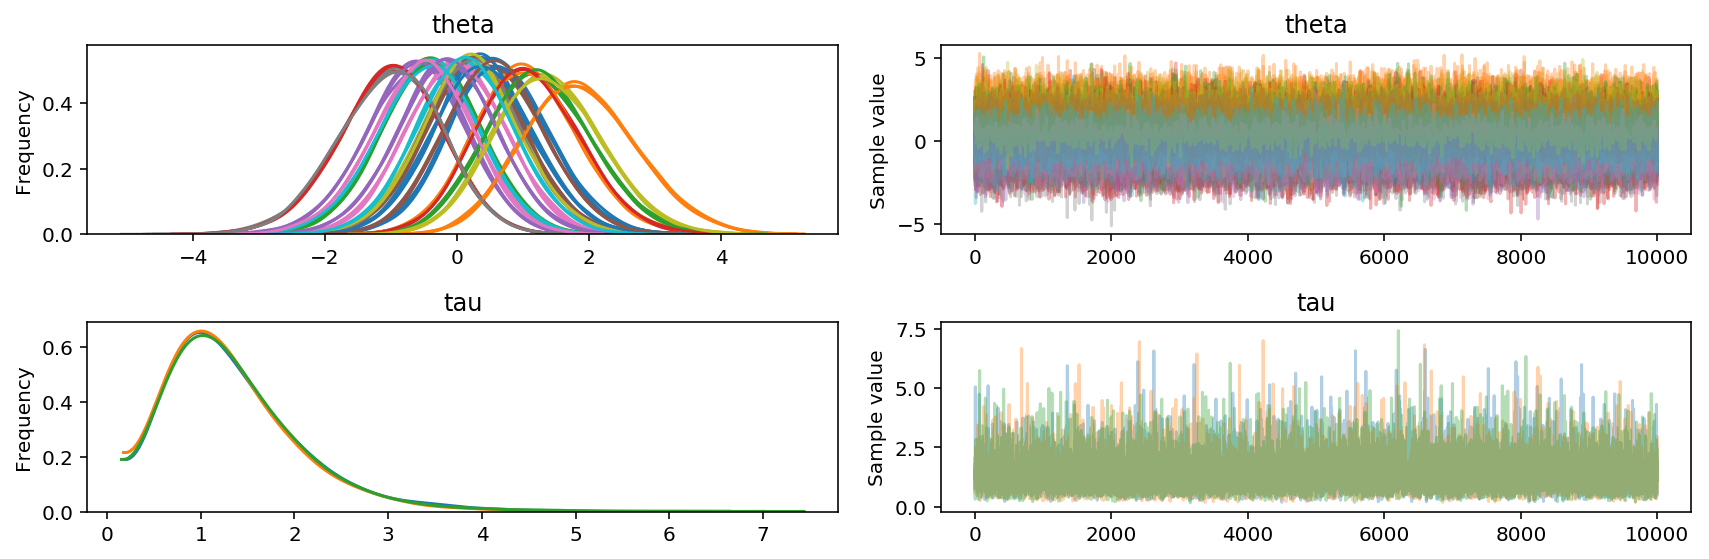

In [36]:
pm.traceplot(trace0);

In [46]:
logml0 = Marginal_llk(trace0, model=H0, maxiter=1000)
print('Bridge sampling estimate of the log marginal likelihood: %.5f'
      %(logml0['logml']))

Bridge sampling estimate of the log marginal likelihood: -37.53822


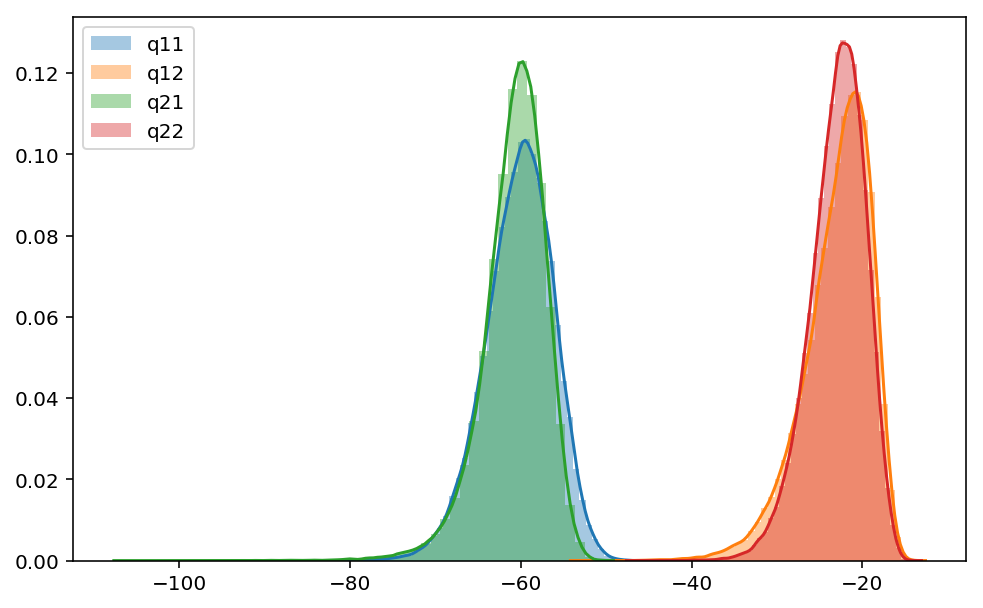

In [47]:
_, ax=plt.subplots(1,1,figsize=(8,5))
for dist in ['q11', 'q12', 'q21', 'q22']:
    sns.distplot(logml0[dist], ax=ax, label=dist)
plt.legend();

The above figure shows:  
`q11` - the Model log-liklihood of the posterior sample  
`q12` - the Multivariate Normal log-liklihood of the posterior sample  
`q21` - the Model log-liklihood of the generated sample  
`q22` - the Multivariate Normal log-liklihood of the generated sample  

With these information, you can then compute the error measures for estimated marginal likelihood. In the R package a function `coda::spectrum0.ar` is called, here I wrote a version using `AR` from `statsmodels` - result might differ a little bit.

In [39]:
from scipy.linalg import lstsq
from statsmodels.tsa.ar_model import AR
def spectrum0_ar(x):
    """Port of spectrum0.ar from coda::spectrum0.ar"""
    z = np.arange(1, len(x)+1)
    z = z[:, np.newaxis]**[0, 1]
    p, res, rnk, s = lstsq(z, x)
    residuals = x - np.matmul(z, p)
    
    if residuals.std() == 0:
        spec = order = 0
    else:
        ar_out = AR(x).fit(ic='aic', trend='c')
        order = ar_out.k_ar
        spec = np.var(ar_out.resid)/(1 - np.sum(ar_out.params[1:]))**2
        
    return spec, order

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-macosx-10.6-intel.egg/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
def error_measures(logml):
    """Port of the error_measures.R in bridgesampling 
    https://github.com/quentingronau/bridgesampling/blob/master/R/error_measures.R
    """
    ml = np.exp(logml['logml'])
    g_p = np.exp(logml['q12'])
    g_g = np.exp(logml['q22'])
    priorTimesLik_p = np.exp(logml['q11'])
    priorTimesLik_g = np.exp(logml['q21'])
    p_p = priorTimesLik_p/ml
    p_g = priorTimesLik_g/ml

    N1 = len(p_p)
    N2 = len(g_g)
    s1 = N1/(N1 + N2)
    s2 = N2/(N1 + N2)

    f1 = p_g/(s1*p_g + s2*g_g)
    f2 = g_p/(s1*p_p + s2*g_p)
    rho_f2, _ = spectrum0_ar(f2)

    term1 = 1/N2 * np.var( f1 ) / np.mean( f1 )**2
    term2 = rho_f2/N1 * np.var( f2 ) / np.mean( f2 )**2

    re2 = term1 + term2

    # convert to coefficient of variation (assumes that bridge estimate is unbiased)
    cv = np.sqrt(re2)

    return dict(re2 = re2, cv = cv)

In [48]:
print('The percentage errors of the estimation is: %.5f'
      %(error_measures(logml0)['cv']*100))

The percentage errors of the estimation is: 0.14164


(The error is larger than in the R example, because here I am using 5 times less samples.)

In [49]:
logml1 = Marginal_llk(trace1, model=H1, maxiter=1000)
print('Bridge sampling estimate of the log marginal likelihood: %.5f'
      %(logml1['logml']))

Bridge sampling estimate of the log marginal likelihood: -37.79922


In [50]:
print('The percentage errors of the estimation is: %.5f'
      %(error_measures(logml1)['cv']*100))

The percentage errors of the estimation is: 0.15991


In [51]:
BF01 = np.exp(logml0['logml'] - logml1['logml'])
print('The estimated Bayes factor in favor of Model_1 over Model_2 is equal to: %.5f'
      %(BF01))

The estimated Bayes factor in favor of Model_1 over Model_2 is equal to: 1.29822


The result is pretty much the same as in the R example.

There is also another way to compute marginal likelihood in PyMC3, using Sequential Monte Carlo sampler. You can find more information about it in the [Documentation](http://docs.pymc.io/notebooks/Bayes_factor.html).  
**!Warning!: This can take a while to sample.**

In [37]:
#SMC related set up
from tempfile import mkdtemp
test_folder = mkdtemp(prefix='SMC_TEST')
n_steps = 20
n_chains = 1000

from pymc3.step_methods import smc
with pm.Model() as H0_:
    tau0 = pm.InverseGamma('tau', alpha, beta, transform=None)
    theta0 = pm.Normal('theta', 0, tt.sqrt(tau0), shape=n)
    obs0 = pm.Normal('y', theta0, np.sqrt(sigma2), observed=y)
    trace0_ = smc.sample_smc(n_steps=n_steps,
                               n_chains=n_chains,
                               progressbar=False,
                               homepath=test_folder,
                               stage=0)

with pm.Model() as H1_:
    mu1 = pm.Normal('mu', mu0, np.sqrt(tau20))
    tau1 = pm.InverseGamma('tau', alpha, beta, transform=None)
    theta1 = pm.Normal('theta', mu1, tt.sqrt(tau1), shape=n)
    obs1 = pm.Normal('y', theta1, np.sqrt(sigma2), observed=y)
    trace1_ = smc.sample_smc(n_steps=n_steps,
                             n_chains=n_chains,
                             progressbar=False,
                             homepath=test_folder,
                             stage=0)

/home/laoj/Documents/Github/pymc3/pymc3/step_methods/smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.044787 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.082467 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.124089 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.181498 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.274007 Stage: 5
Initialising chain traces ...
Sampling ...
Beta: 0.437268 Stage: 6
Initial

In [38]:
print('SMC estimate of log marginal likelihood for H0 is: %.5f'
      %(np.log(H0_.marginal_likelihood)))
print('SMC estimate of log marginal likelihood for H1 is: %.5f'
      %(np.log(H1_.marginal_likelihood)))

SMC estimate of log marginal likelihood for H0 is: -15.20573
SMC estimate of log marginal likelihood for H1 is: -16.49513


In [39]:
BF01_ = H0_.marginal_likelihood / H1_.marginal_likelihood
print('The estimated Bayes factor in favor of Model_1 over Model_2 is equal to: %.5f'
      %(BF01_))

The estimated Bayes factor in favor of Model_1 over Model_2 is equal to: 3.63061


The estimated marginal likelihood is not the same as the one estimated using the Bridge sampling, and the Bayes factor is quite different as well. I guess it is time to double check the marginal likelihood estimation in SMC.